# Regressione robusta {#sec-robust-regression}

**Prerequisiti**

**Concetti e competenze chiave**

**Preparazione del Notebook**

In [2]:
import warnings
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
warnings.filterwarnings("ignore")

In [3]:
seed: int = sum(map(ord, "robust_regression"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

## Introduzione {.unnumbered}

Nell'ambito della psicologia, la gestione efficace dei dati anomali è cruciale per garantire l'integrità e l'affidabilità delle inferenze statistiche. La regressione robusta bayesiana rappresenta un approccio metodologico avanzato, specificamente progettato per affrontare le sfide poste da distribuzioni dei dati caratterizzate da deviazioni significative dalla norma, comuni nei dataset psicologici. Questo capitolo si dedica all'esplorazione dettagliata della regressione robusta bayesiana, con un focus particolare sull'impiego della distribuzione Student-t come modello di errore per accrescere la tolleranza ai dati anomali e sul Pareto Smoothed Importance Sampling (PSIS) per individuare la presenza di dati anomali.

## Introduzione alla Gestione degli Outlier nelle Analisi Dati

Le osservazioni anomale, comunemente note come outlier, ovvero i valori che si situano ai margini della distribuzione complessiva dei dati, hanno un ruolo fondamentale nell'analisi statistica. La loro presenza, infatti, può seriamente compromettere l'integrità e la validità predittiva di un modello statistico, evidenziando una potenziale inadeguatezza del modello stesso nel rappresentare con precisione l'eterogeneità intrinseca dei dati. Questi valori estremi sono indicativi di limitazioni nel modello, suggerendo che esso potrebbe non essere configurato correttamente o che possa non essere in grado di catturare tutte le dinamiche sottostanti i dati. Pertanto, l'identificazione e l'analisi approfondita degli outlier sono essenziali per garantire che le inferenze e le previsioni generate da un modello statistico siano robuste e affidabili.

Ignorare o rimuovere gli outlier senza un'accurata valutazione delle loro cause e caratteristiche può portare a interpretazioni errate dei dati. Tale pratica può essere paragonata a un tentativo di "correzione" dei dati piuttosto che a un miglioramento del modello, nascondendo di fatto i veri problemi anziché risolverli. Di conseguenza, la sfida principale consiste nel comprendere l'impatto degli outlier sul modello e nel trovare strategie per integrare queste informazioni anziché escluderle, considerandoli un elemento informativo cruciale nell'analisi complessiva.

Per affrontare gli outlier in modo efficace, è essenziale adottare approcci statistici robusti. Questi possono includere la modifica della funzione di verosimiglianza per aumentare la tolleranza nei confronti di variazioni estreme dei dati, l'impiego di distribuzioni a priori che ammettano esplicitamente la presenza di deviazioni significative, o l'utilizzo di metodi specifici per identificare e analizzare gli outlier.

In sintesi, gli outlier non dovrebbero essere visti come un problema da evitare, ma piuttosto come un'occasione per affinare e perfezionare i modelli statistici. La rimozione degli outlier senza un'adeguata analisi può condurre a conclusioni fuorvianti e a previsioni poco affidabili. Al contrario, un esame dettagliato e l'integrazione consapevole degli outlier possono arricchire la nostra comprensione del fenomeno studiato, migliorando la precisione e l'affidabilità delle previsioni del modello.

## Mistura di Gaussiane 

Nel presente capitolo, esploreremo una metodologia avanzata per mitigare l'effetto degli outlier attraverso l'ottimizzazione della funzione di verosimiglianza, incrementando così la sua robustezza nei confronti di deviazioni estreme nei dati. Una tattica particolarmente efficace per raggiungere tale obiettivo implica l'utilizzo della distribuzione t di Student nella modellazione dei dati. In particolare, nel contesto dell'analisi di regressione, è stato evidenziato come gli outlier possano influenzare negativamente la retta di regressione, facendola deviare dalle zone di maggiore densità dei dati. Attraverso l'utilizzo della distribuzione t di Student, la quale presenta code più pesanti rispetto alla distribuzione Gaussiana (Normale), è possibile ridurre l'impatto distorsivo degli outlier sulla retta di regressione. Questo rappresenta un esempio classico di regressione robusta.

La distribuzione t di Student può essere compresa concettualmente come una composizione di diverse distribuzioni gaussiane, ognuna con la propria varianza specifica. Questa caratteristica conferisce alla distribuzione una maggiore flessibilità nel trattare dati con varianze estreme, rendendola particolarmente adatta per l'uso in modelli statistici che richiedono una notevole resistenza agli outlier. Utilizzare questa distribuzione facilita l'esecuzione di analisi più robuste e la generazione di previsioni più accurate, migliorando il livello di inferenza in situazioni dove sono presenti dati anomali.

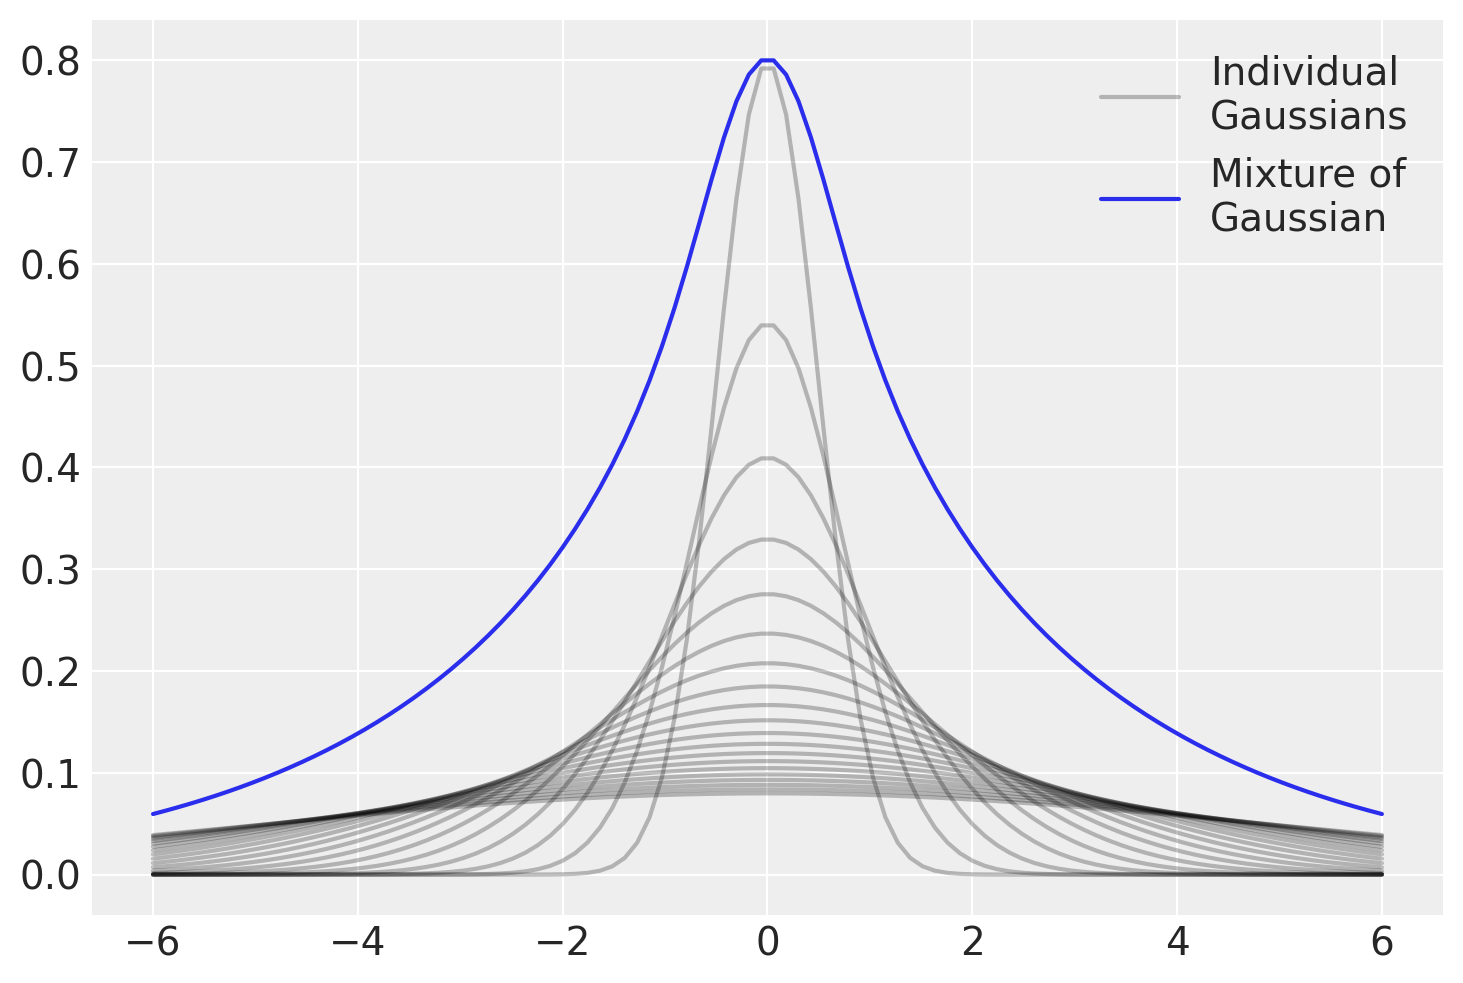

In [4]:
# Creazione dell'array di valori x
xs = np.linspace(-6, 6, 100)

# Inizializzazione dell'array per i PDF (Probability Density Function)
pdfs = []

# Numero di gaussiane
n_gaussians = 20

# Ciclo per tracciare ogni gaussiana
for variance in np.linspace(.5, 5, n_gaussians):
    label = "Individual\nGaussians" if variance == .5 else None
    pdf = stats.norm(0, variance).pdf(xs)
    pdfs.append(pdf)
    plt.plot(xs, pdf, color='k', label=label, alpha=.25)  # Usa matplotlib.pyplot.plot

# Calcolo della somma dei PDFs
sum_of_pdfs = np.array(pdfs).sum(axis=0)
sum_of_pdfs /= sum_of_pdfs.max()
sum_of_pdfs *= (1 - n_gaussians / 100)

# Tracciare la somma dei PDFs
plt.plot(xs, sum_of_pdfs, label='Mixture of\nGaussian')

plt.legend()
plt.show()

La natura della distribuzione t di Student come mistura di Gaussiane porta con sé importanti conseguenze analitiche.

La caratteristica di essere una somma di distribuzioni gaussiane con varianze eterogenee si riflette nella presenza di code più pesanti rispetto a una distribuzione gaussiana singola. Ciò significa che la distribuzione t è in grado di gestire più efficacemente osservazioni estreme, rendendola una scelta preferenziale per dati che si discostano dalla normalità, soprattutto in presenza di outlier. 

In numerosi ambiti si osserva frequentemente la presenza di dati provenienti da popolazioni con caratteristiche eterogenee, talvolta non immediatamente identificabili. Questa diversità può essere il risultato di una varietà di meccanismi sottostanti con varianze distinte. Essendo composta da diverse gaussiane, la distribuzione t di Student incorpora implicitamente l'eterogeneità non osservabile nei dati, che può derivare da diverse fonti con varianze distinte. 

Un'altra caratteristica distintiva della distribuzione t di Student è la sua ridotta sensibilità agli outlier rispetto alla distribuzione gaussiana. Grazie alle sue code più pesanti, la distribuzione t attribuisce una maggiore probabilità alle osservazioni estreme, riducendo l'effetto distorsivo degli outlier sull'analisi statistica. 

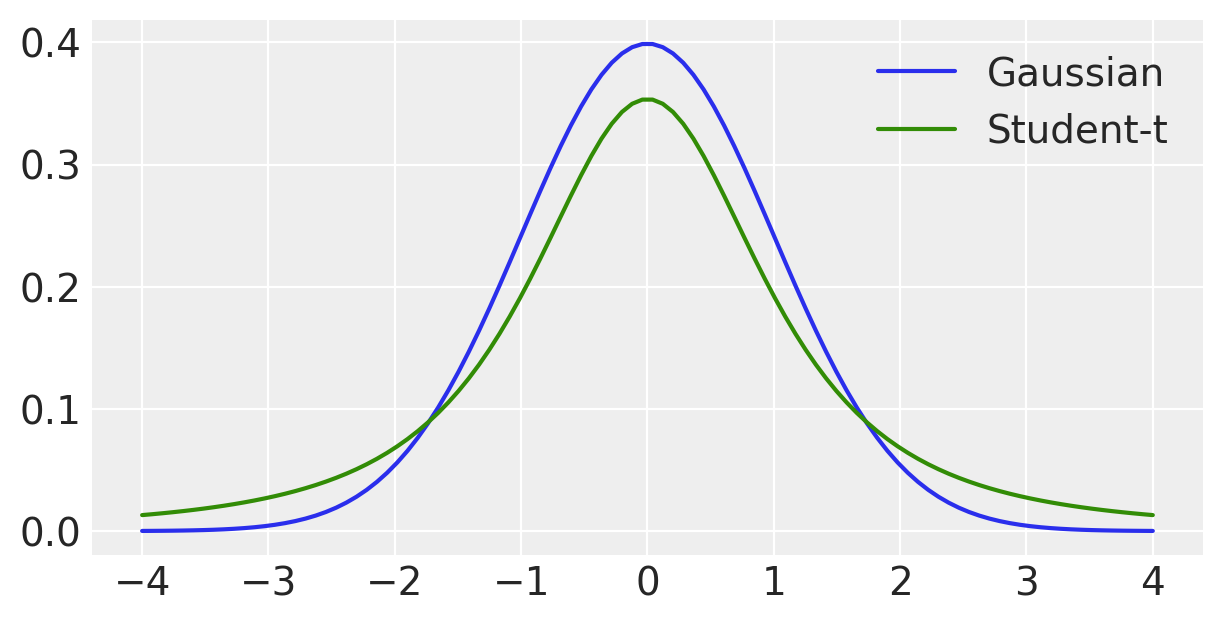

In [5]:
# Creazione dell'array di valori x
xs = np.linspace(-4, 4, 100)

# Configurazione delle dimensioni del grafico
plt.subplots(figsize=(6, 3))

# Tracciare la distribuzione normale (Gaussiana)
plt.plot(xs, stats.norm.pdf(xs), label='Gaussian')

# Tracciare la distribuzione Student-t
plt.plot(xs, stats.t(2).pdf(xs), color='C2', label='Student-t')

plt.legend()
plt.show()

## Un esempio concreto

Per illustrare la capacità della distribuzione t di Student di mitigare l'effetto degli outlier nell'analisi di regressione, in questo capitolo considereremo un set di dati simulati, così come illustrato nel tutorial fornito sul sito di [Bambi](https://bambinos.github.io/bambi/notebooks/t_regression.html).

In [6]:
size = 100
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=0.5, size=size)

# Add outliers
x_out = np.append(x, [0.01, 0.1, 0.15])
y_out = np.append(y, [12, 11, 13])

data = pd.DataFrame({
    "x": x_out,
    "y": y_out
})

Si noti che sono stati introdotti 3 valori anomali nel dataset, nonostante il vero meccanismo generativo dei dati implichi che la pendenza della retta di regressione sia pari a 2.

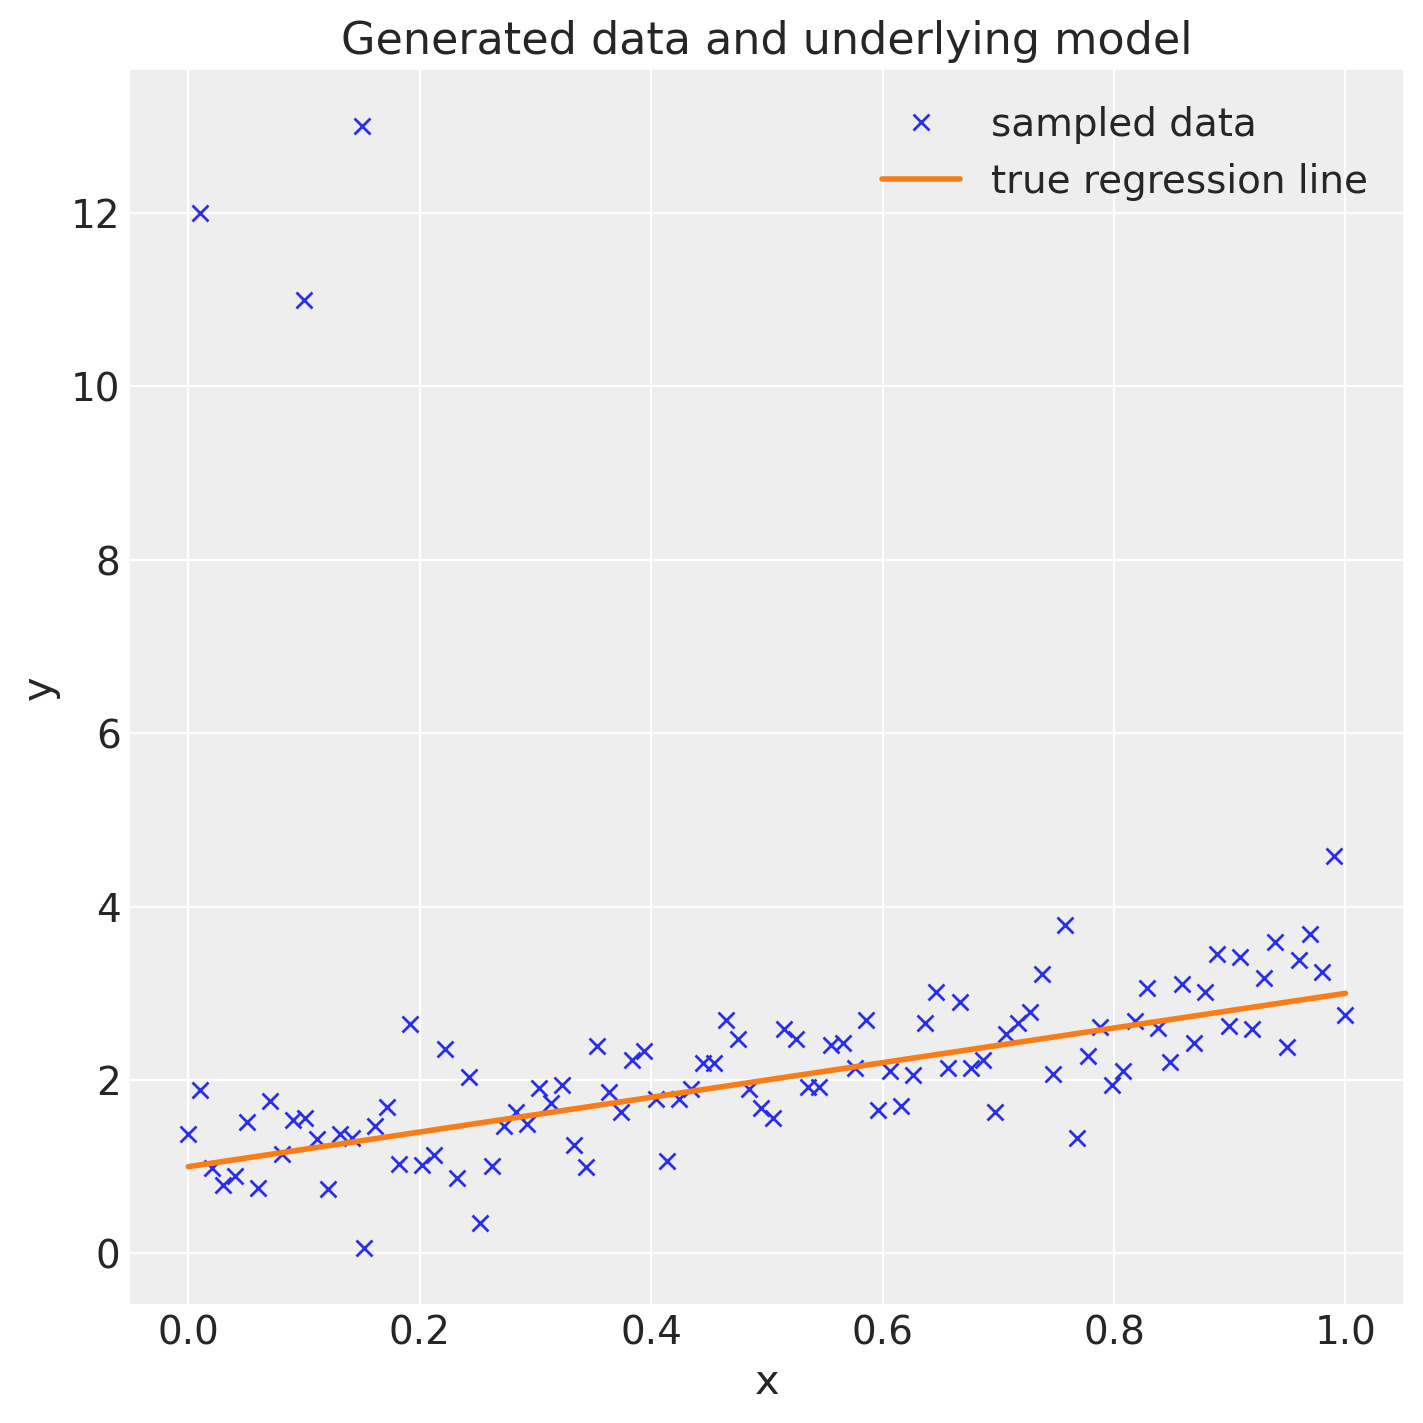

In [7]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x_out, y_out, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

Queste anomalie possono essere soggette ad un'analisi rigorosa mediante l'applicazione di metodi statistici avanzati. Un approccio per valutare l'impatto di tali outlier sull'analisi è l'utilizzo della statistica PSIS $k$, una tecnica che permette di quantificare l'influenza delle osservazioni estreme su una distribuzione.

Implementiamo un modello di regressione lineare per analizzare la relazione tra y (variabile dipendente) e x. In questa analisi iniziale, l'ipotesi sottostante è che gli errori (o residui), seguano una distribuzione normale (gaussiana). 

In [8]:
gauss_model = bmb.Model("y ~ x", data, family="gaussian")

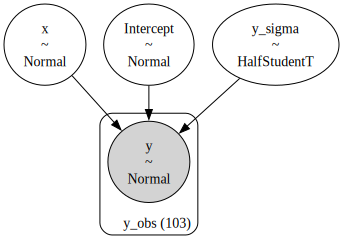

In [9]:
gauss_model.build()
gauss_model.graph()

Adattiamo il modello ai dati. Si noti che l'argomento `idata_kwargs={"log_likelihood": True}` passato alla funzione `fit` è usato per specificare le opzioni per la creazione dell'oggetto `InferenceData` che sarà restituito. In questo caso, stiamo indicando che vogliamo che il logaritmo della verosimiglianza sia incluso nell'oggetto `InferenceData`. Il logaritmo della verosimiglianza può essere utilizzato per ulteriori analisi e diagnostica, come il calcolo del LOO (Leave-One-Out Cross-Validation).

In [10]:
gauss_fitted = gauss_model.fit(
    nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Esaminiamo visivamente i risultati dell'analisi.

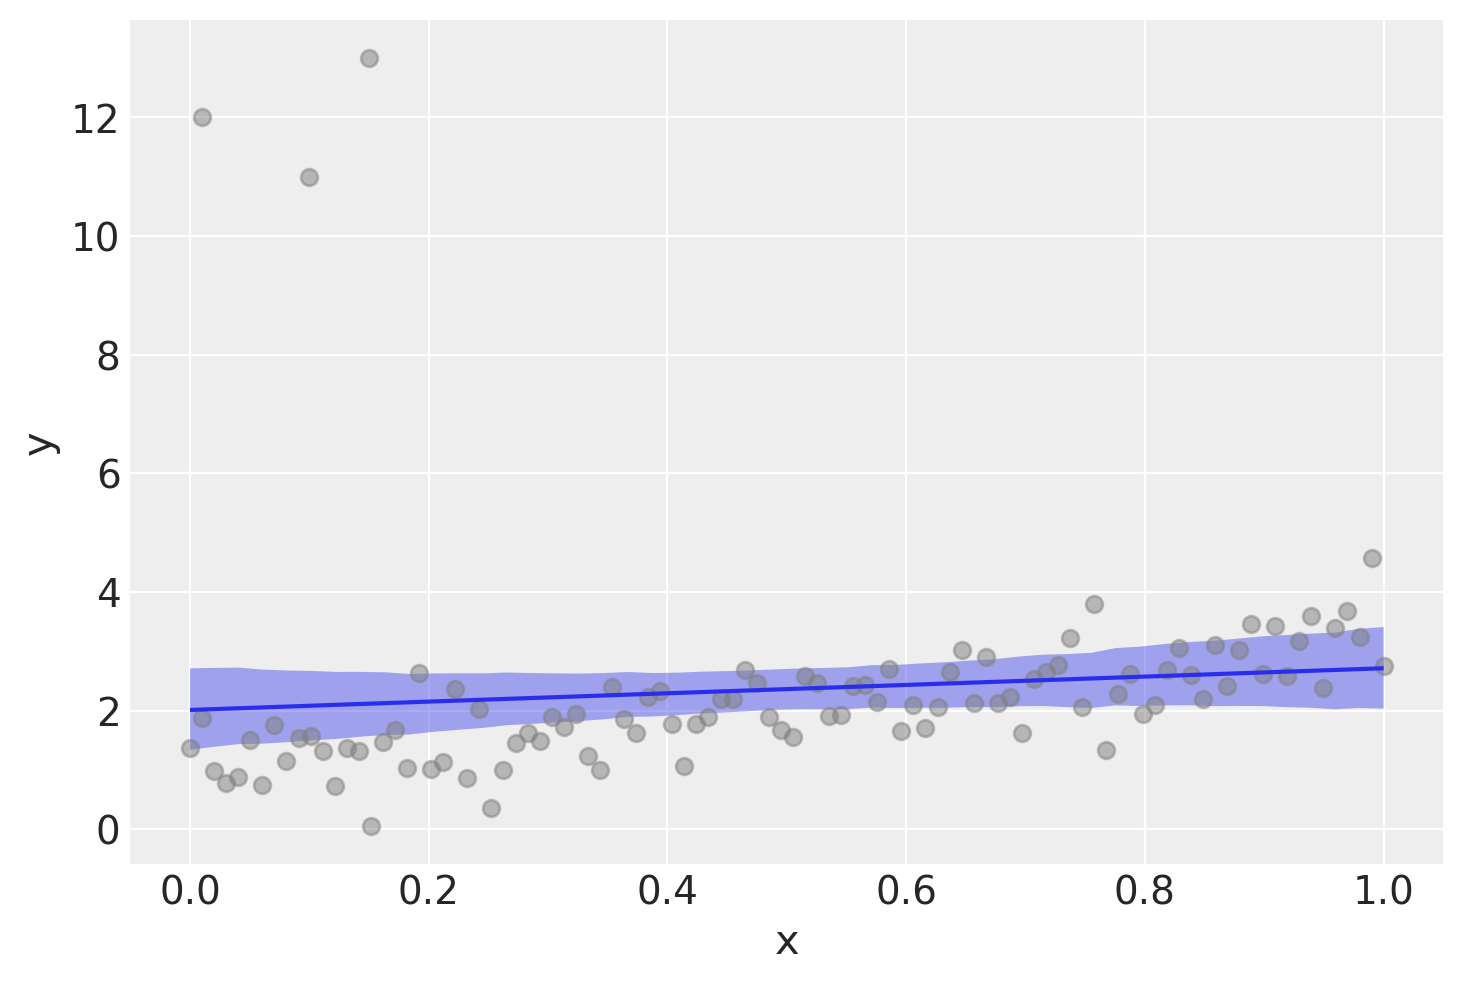

In [11]:
ax = bmb.interpret.plot_predictions(gauss_model, gauss_fitted, ["x"])
plt.scatter(data['x'], data['y'], color='gray', alpha=0.5, label='Dati Grezzi')
plt.show()

Ipotizzando una distribuzione normale degli errori, l'analisi produce una stima fortemente distorta della pendenza della retta di regressione.

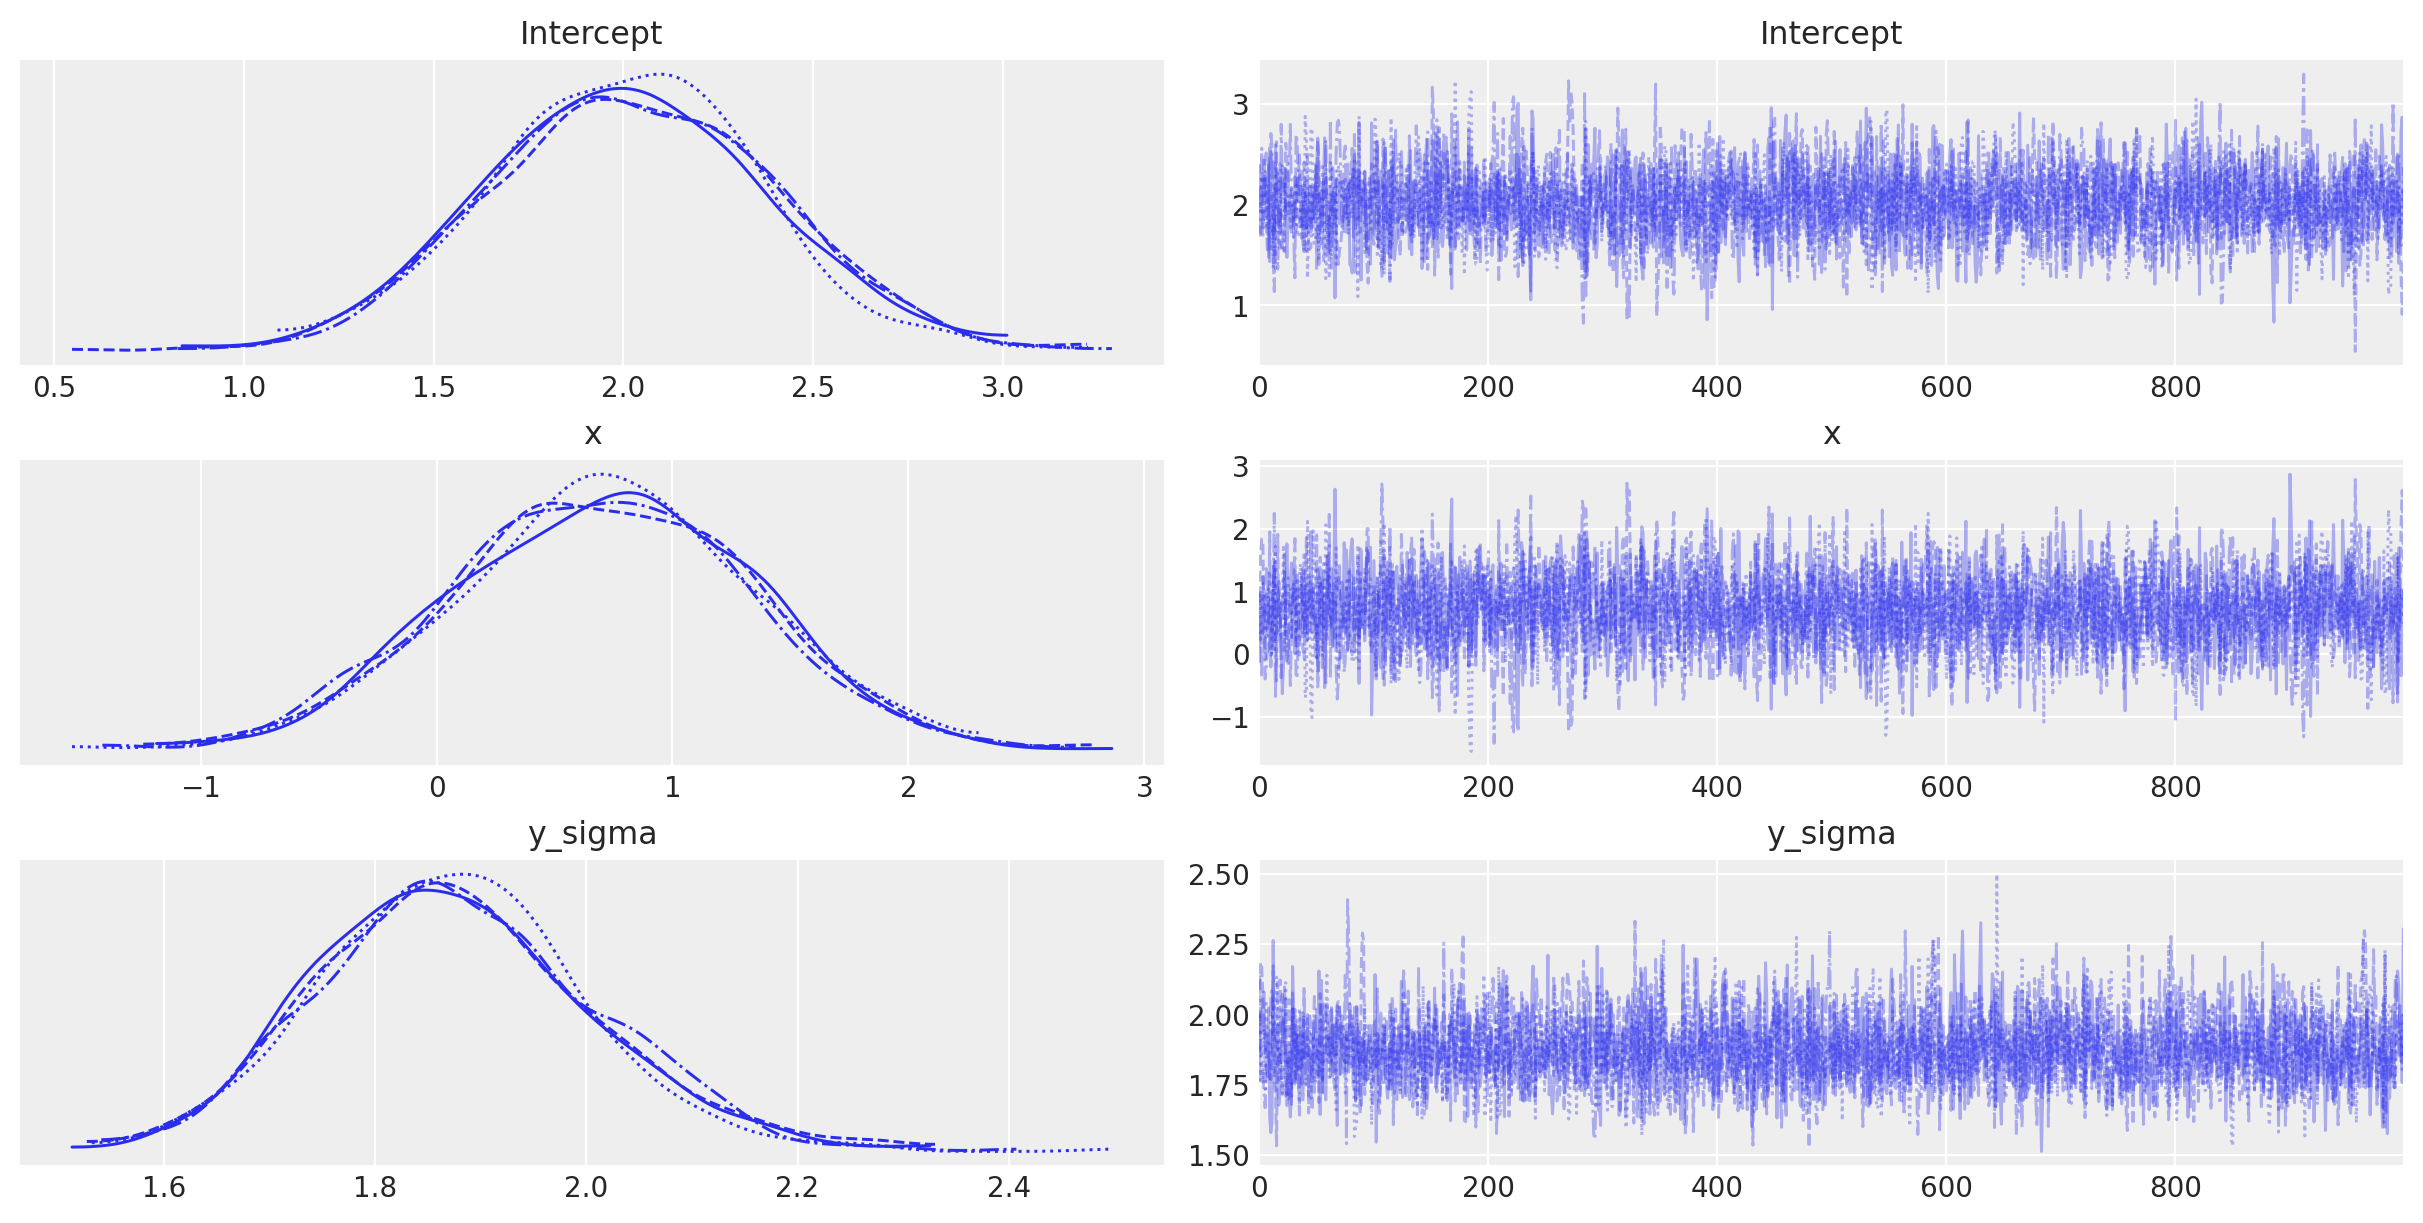

In [12]:
_ = az.plot_trace(gauss_fitted)

In [13]:
az.summary(gauss_fitted, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.01,0.37,1.34,2.71,0.01,0.00,3706.05,2924.03,1.0
x,0.70,0.63,-0.43,1.91,0.01,0.01,3728.06,3011.37,1.0
y_sigma,1.88,0.13,1.64,2.12,0.00,0.00,3760.28,2821.34,1.0


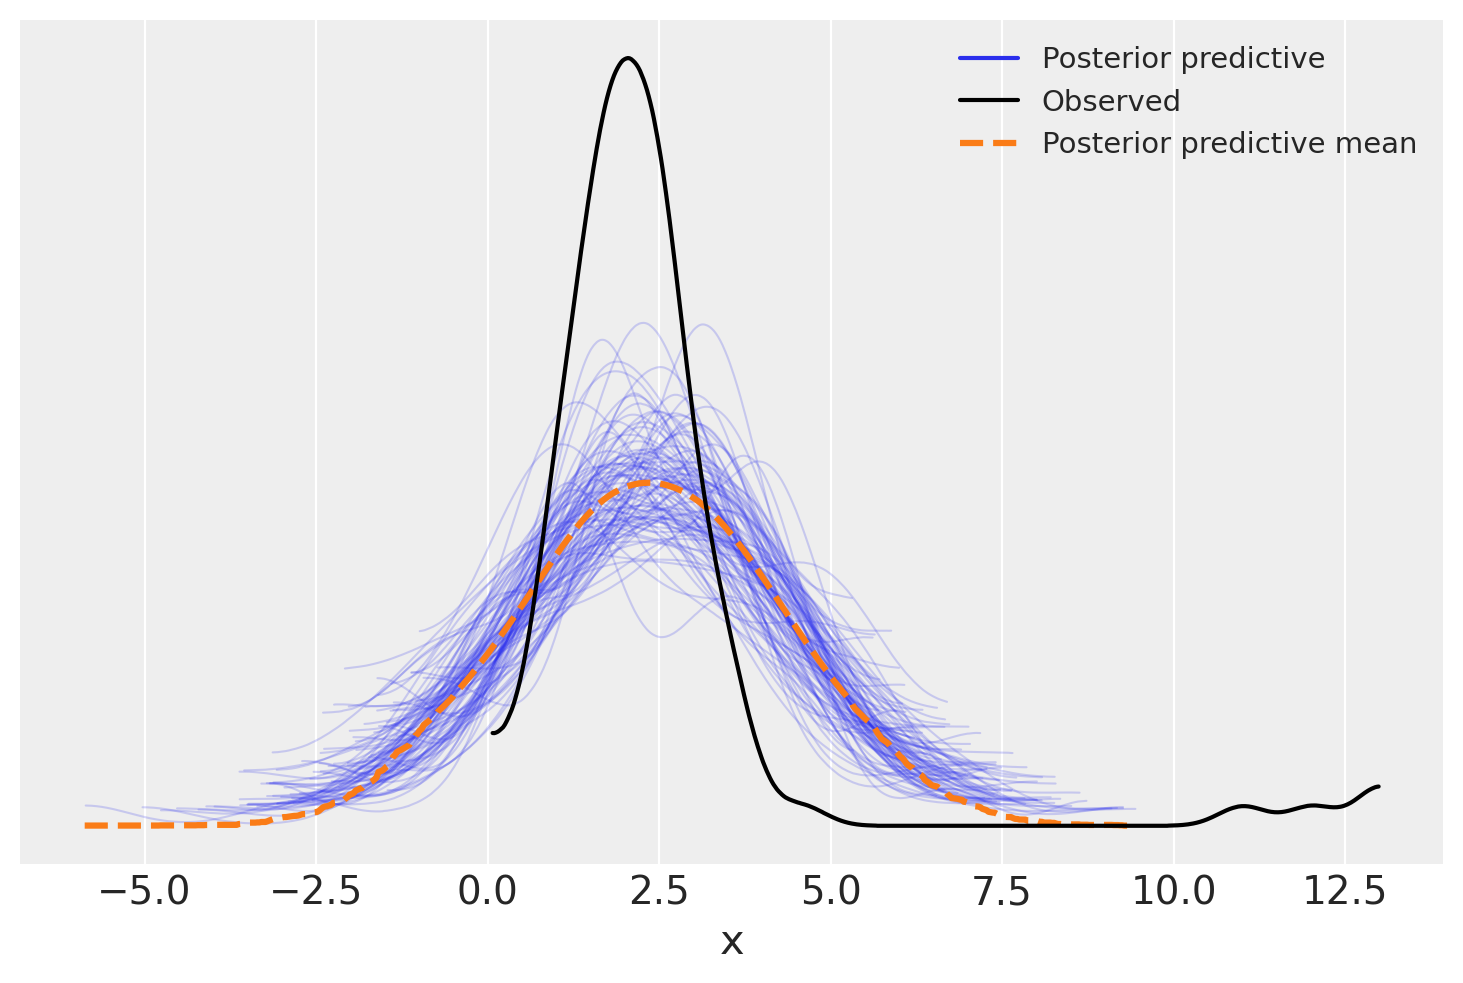

In [14]:
posterior_predictive = gauss_model.predict(gauss_fitted, kind="pps")
ax = az.plot_ppc(gauss_fitted, num_pp_samples=100)
_ = ax.set_xlabel("x")

In un secondo modello assumiamo che gli errori seguano una distribuzione t di Student.

In [15]:
t_model = bmb.Model("y ~ x", data, family="t")

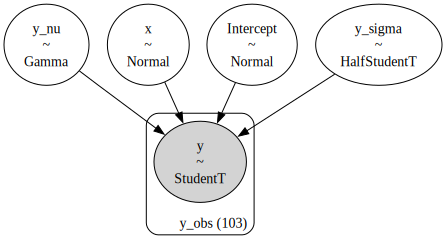

In [16]:
t_model.build()
t_model.graph()

In [17]:
t_fitted = t_model.fit(
    nuts_sampler="numpyro",
    idata_kwargs={"log_likelihood": True}
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

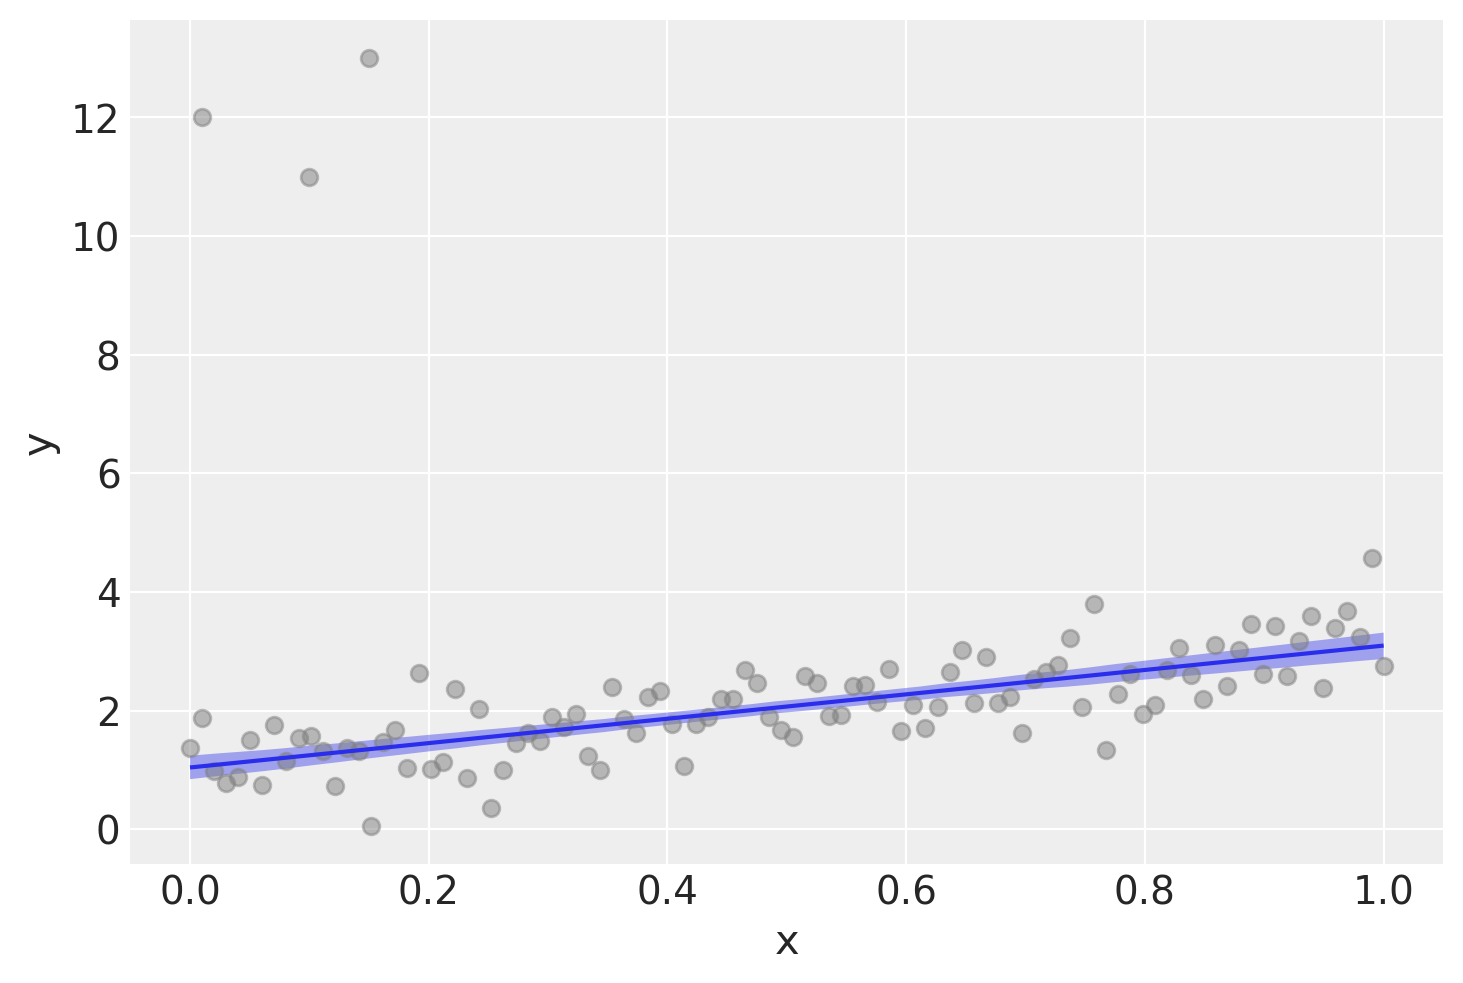

In [18]:
ax = bmb.interpret.plot_predictions(t_model, t_fitted, ["x"])
_ = plt.scatter(data['x'], data['y'], color='gray', alpha=0.5, label='Dati Grezzi')

Si noti che, in questo caso, la presenza degli outlier non ha distorto in alcun modo la stima della pendenza della retta di regressione. Nella regressione lineare gaussiana classica, i valori anomali hanno l'effetto di "spingere" la distribuzione a posteriori di $\beta$ verso lo zero. Invece, il modello student-t è più robusto e meno influenzato dai valori anomali.

In [19]:
az.summary(t_fitted, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.04,0.11,0.85,1.24,0.00,0.00,4097.93,3047.07,1.0
x,2.05,0.20,1.69,2.43,0.00,0.00,3904.75,2603.76,1.0
y_nu,2.11,0.43,1.35,2.89,0.01,0.01,3372.83,3184.83,1.0
y_sigma,0.41,0.05,0.33,0.50,0.00,0.00,3528.66,2898.77,1.0


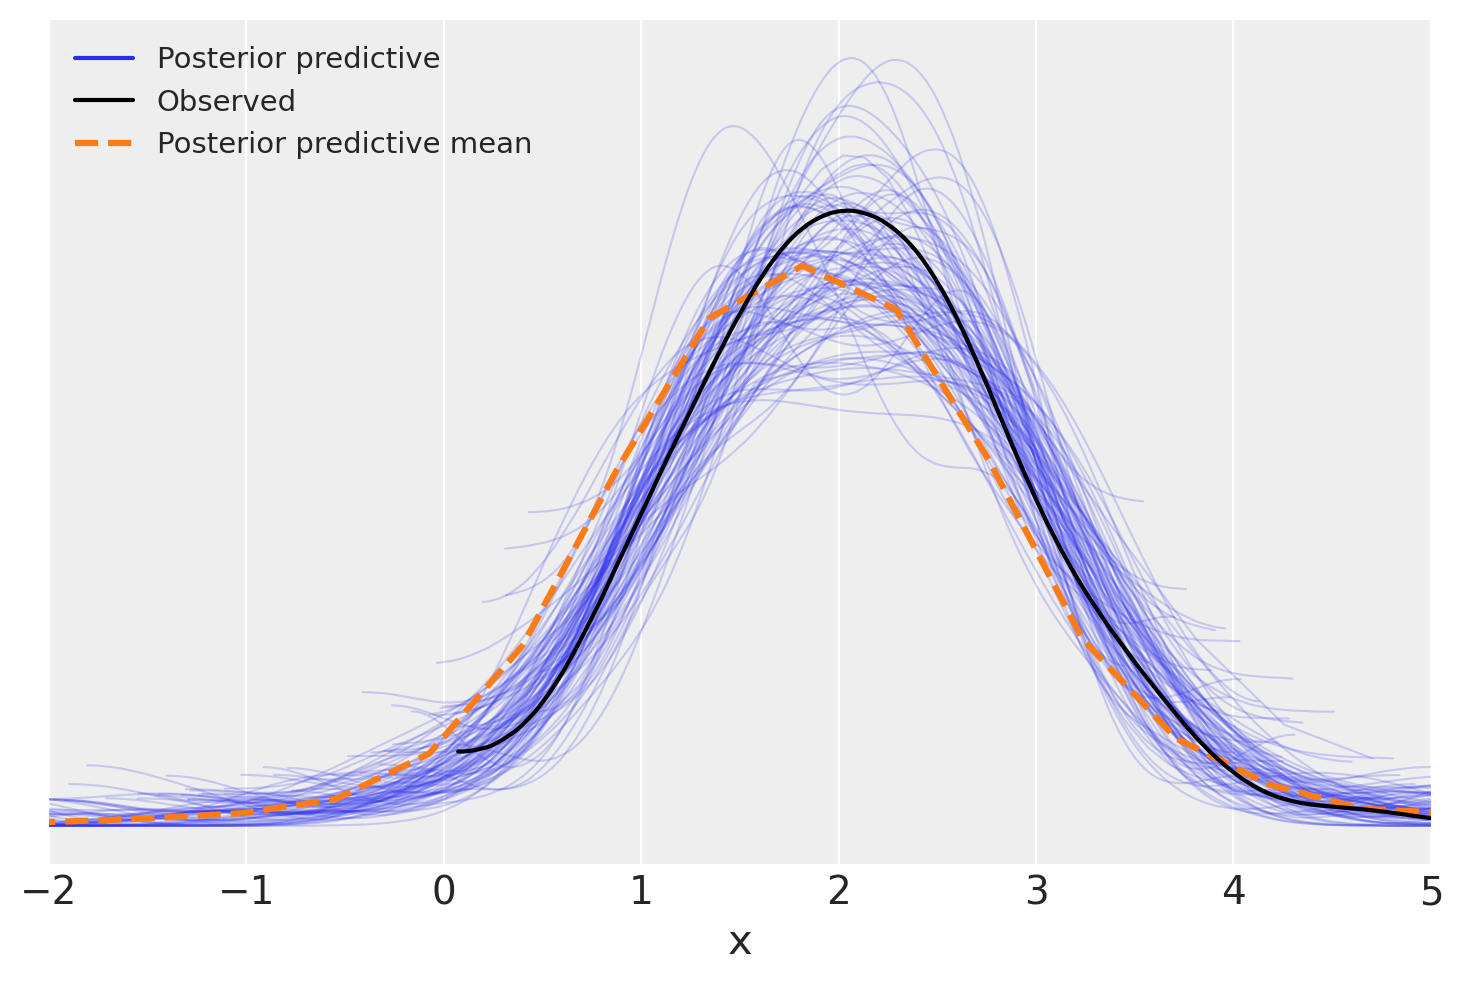

In [20]:
posterior_predictive = t_model.predict(t_fitted, kind="pps")
ax = az.plot_ppc(t_fitted, num_pp_samples=100)
plt.xlim(-2, 5)
_ = ax.set_xlabel("x")

Nella figura successiva, esaminiamo la stima a posteriori della pendenza della retta di regressione per entrambi i modelli.

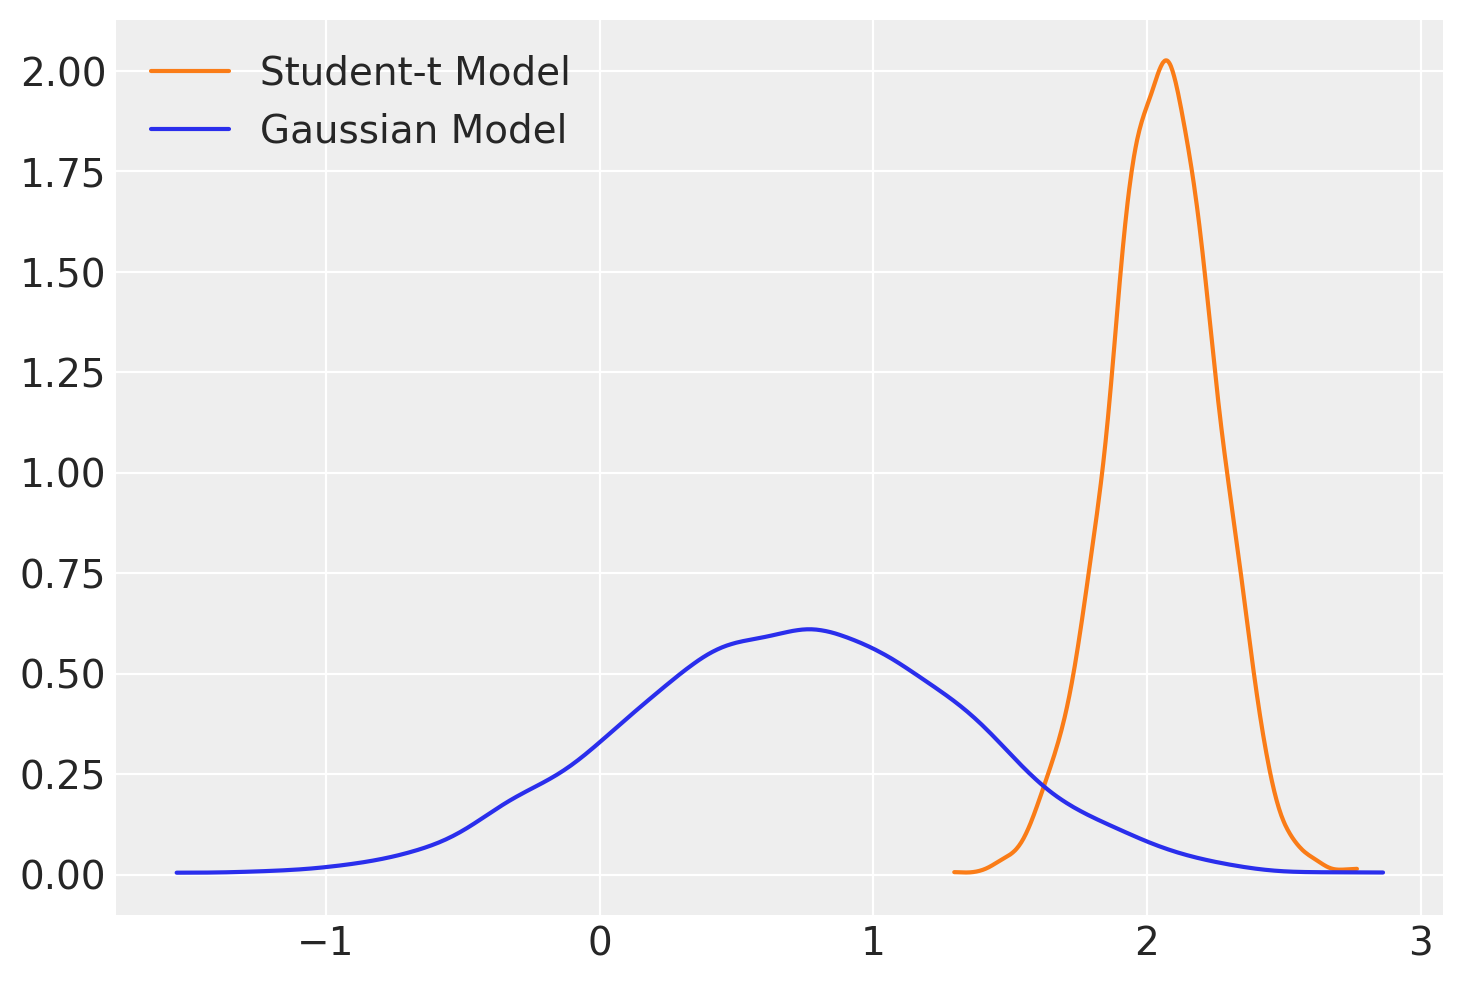

In [21]:
az.plot_dist(t_fitted.posterior["x"], color="C1", label="Student-t Model")
az.plot_dist(gauss_fitted.posterior["x"], label="Gaussian Model");

Si noti che, in presenza di outlier, l'impiego della distribuzione t di Student ha portato a un adattamento del modello più accurato, come evidenziato dai valori diagnostici Pareto $k$.

In [22]:
az.loo(gauss_fitted)

Computed from 4000 posterior samples and 103 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -218.88    29.25
p_loo       14.25        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100   97.1%
 (0.5, 0.7]   (ok)          1    1.0%
   (0.7, 1]   (bad)         2    1.9%
   (1, Inf)   (very bad)    0    0.0%

In [23]:
az.loo(t_fitted)

Computed from 4000 posterior samples and 103 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -113.58    16.36
p_loo        5.55        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100   97.1%
 (0.5, 0.7]   (ok)          3    2.9%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

## WAIC e PSIS

Nella sezione seguente, approfondiremo il legame tra i valori diagnostici di Pareto $k$ e il *Watanabe-Akaike Information Criterion* (WAIC), una metrica essenziale per valutare la qualità di un modello statistico. A differenza del più tradizionale criterio di informazione di Akaike (AIC), impiegato nei contesti frequentisti, il WAIC estende il concetto di valutazione della qualità di un modello incorporando sia la sua capacità di adattamento ai dati sia la sua complessità intrinseca. Lo scopo è prevenire l'eccesso di adattamento (overfitting), dove il modello è troppo specifico ai dati di addestramento, e l'insufficiente adattamento (underfitting), dove il modello è troppo semplice per catturare la struttura sottostante dei dati. In termini più accessibili, il WAIC stima l'efficacia con cui un modello può prevedere dati non ancora osservati, basandosi sulla log-verosimiglianza dei dati e correggendo per la dimensione effettiva del modello. Un valore WAIC inferiore segnala una maggiore capacità previsionale del modello.

Per calcolare il WAIC, si fa spesso ricorso all'*importance sampling*, una tecnica per approssimare proprietà di una distribuzione di probabilità campionando da una distribuzione alternativa. Il PSIS (*Pareto Smoothed Importance Sampling*), che migliora questo metodo, e i valori diagnostici di Pareto $k$ giocano un ruolo cruciale nell'evaluazione della qualità dell'approximation impiegata per il calcolo del WAIC. Il valore di Pareto $k$ funge da termometro dell'efficacia dell'*importance sampling* per un determinato modello e insieme di dati. Valori elevati di Pareto $k$ (solitamente oltre 0.7) segnalano potenziali inaffidabilità nell'approssimazione, il che può tradursi in stime del WAIC distorte. Questo fenomeno suggerisce che il modello potrebbe non essere adeguatamente equipaggiato per prevedere specifiche osservazioni nei dati, spesso a causa della presenza di dati anomali o di una scarsa adattabilità del modello.

Stabilire un collegamento tra WAIC e i valori di Pareto $k$ è fondamentale, poiché offre una panoramica più dettagliata e affidabile della performance di un modello. Se da un lato il WAIC valuta l'adattabilità generale del modello ai dati e la sua gestione della complessità, dall'altro, il valore di Pareto $k$ fornisce insight preziosi sull'affidabilità dell'approssimazione usata per il suo calcolo. Insieme, queste metriche consentono una valutazione più completa della qualità di un modello.

Quando il calcolo del WAIC viene eseguito in modo puntiforme (`pointwise=True`), significa che la valutazione è condotta separatamente per ciascuna osservazione all'interno del dataset. Questa modalità di calcolo permette di identificare come ogni dato contribuisca al valore globale del WAIC, facilitando l'individuazione di potenziali dati anomali o punti critici per il modello, diversamente da un calcolo aggregato che fornirebbe un unico valore di WAIC per tutto il modello. Questa analisi dettagliata è particolarmente utile per affinare la comprensione della performance modello e per guidare eventuali miglioramenti.

In [24]:
def plot_loocv(inference, title=None, outliers_idx=[], divorce=None):
    plt.subplots(figsize=(6, 3))
    pareto_k = az.loo(inference, pointwise=True).pareto_k
    waic = -az.waic(inference, pointwise=True).waic_i

    plt.scatter(pareto_k, waic, color='C0', label=None)

    # Assicurati che outliers_idx e divorce siano definiti
    for oi in outliers_idx:
        if divorce is not None and oi in divorce.index:
            plt.annotate(divorce.loc[oi, "Location"], (pareto_k[oi] + .01, waic[oi]), fontsize=14)

    plt.xlabel("PSIS Pareto K")
    plt.ylabel("WAIC")
    plt.title(title)
    plt.show()

Creiamo un grafico che mostra i valori di WAIC in funzione dei valori Pareto $k$. Con questa rappresentazione possiamo esaminare come ogni osservazione influisca sulla performance del modello e sulla sua affidabilità. Se un punto ha un alto valore di Pareto $k$ e un elevato impatto negativo sul WAIC (indicato da un alto valore negativo di WAIC), potrebbe essere un candidato per un'ulteriore revisione o esclusione dal modello.

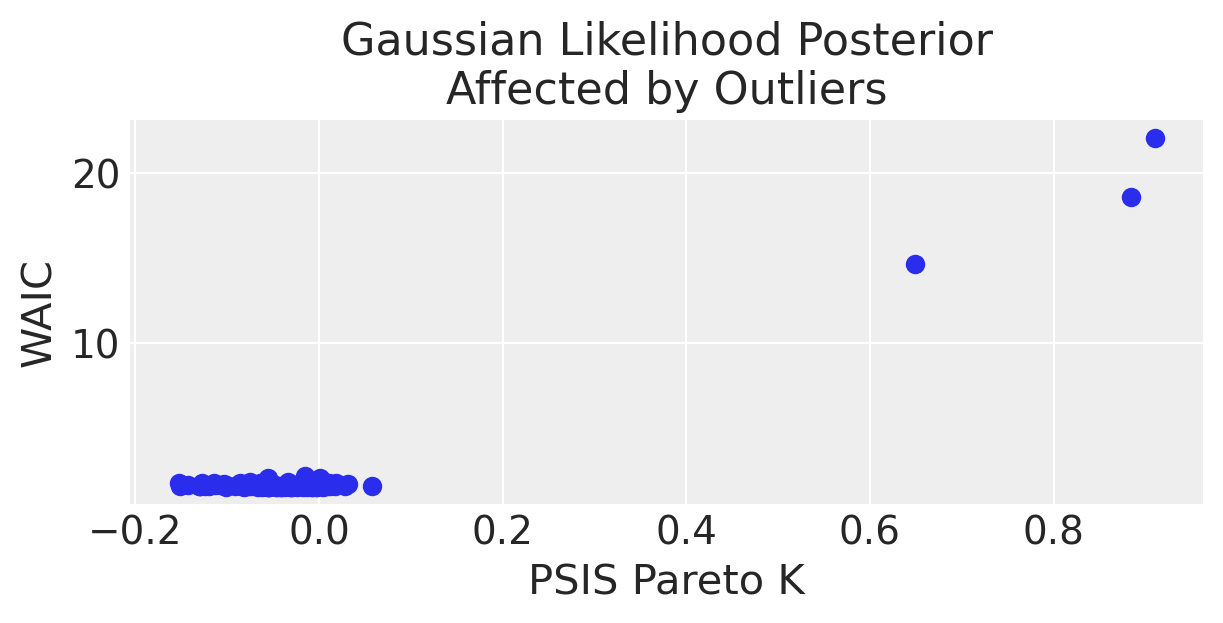

In [25]:
plot_loocv(gauss_fitted, title="Gaussian Likelihood Posterior\nAffected by Outliers")

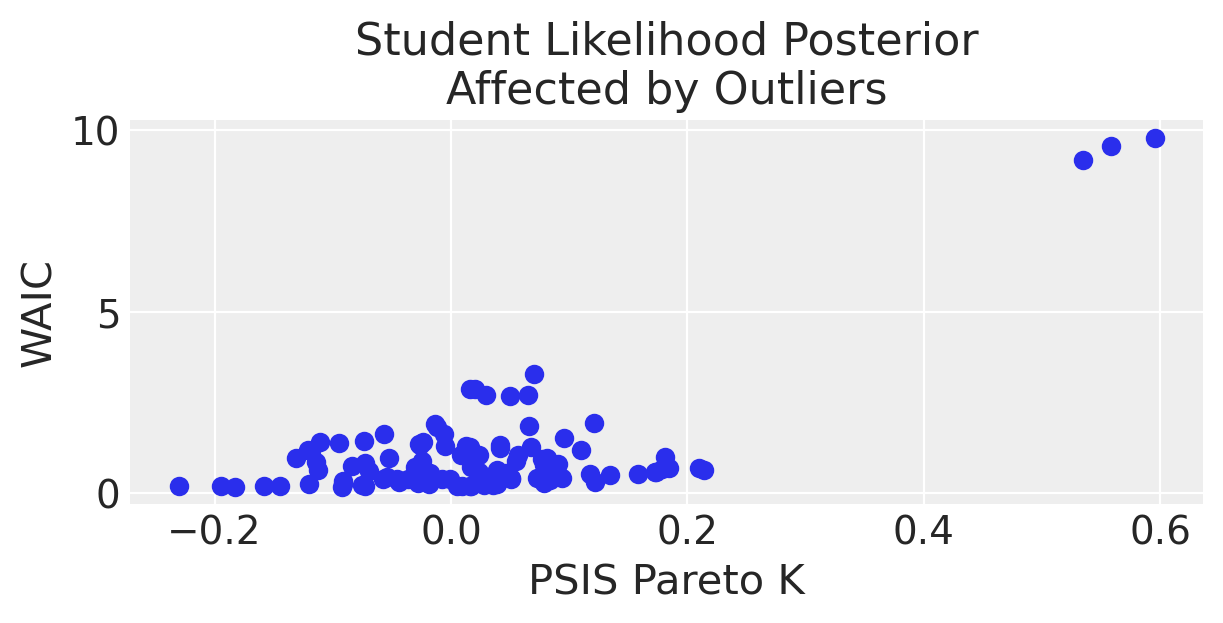

In [26]:
plot_loocv(t_fitted, title="Student Likelihood Posterior\nAffected by Outliers")

È evidente che, per i dati in esame, quando si utilizza un modello di regressione lineare che assume una distribuzione degli errori t di Student, sia il WAIC che i valori diagnostici Pareto $k$ risultano essere inferiori. Questa riduzione indica una maggiore efficienza del modello nella previsione dei dati.

## Confronto tra Modelli

Eseguiamo ora un'analisi di validazione incrociata Leave-One-Out (LOO) per confrontare i due modelli statistici, il modello gaussiano e il modello basato sulla distribuzione t di Student. L'analisi di validazione incrociata Leave-One-Out (LOO) è una tecnica di valutazione dei modelli statistici che consente di confrontare le loro prestazioni in termini di capacità previsionale. Questo metodo è particolarmente utile per determinare quale modello possa generalizzare meglio a nuovi dati, non inclusi nel set di addestramento. 

L'analisi di validazione incrociata Leave-One-Out (LOO) è una tecnica di valutazione dei modelli statistici che consente di confrontare le loro prestazioni in termini di capacità previsionale. Questo metodo è particolarmente utile per determinare quale modello possa generalizzare meglio a nuovi dati, non inclusi nel set di addestramento. Ecco una spiegazione dettagliata del processo e di come viene applicato per confrontare un modello gaussiano con un modello basato sulla distribuzione t di Student.

Nello specifico, la validazione incrociata LOO è un caso particolare di validazione incrociata k-fold, dove $k$ è uguale al numero di osservazioni nel dataset. In pratica, questo significa che per un dataset di $n$ osservazioni, il modello viene addestrato $n$ volte, ogni volta usando $n-1$ osservazioni come dati di addestramento e la singola osservazione restante come dato di test. Questo processo viene ripetuto per ogni osservazione nel dataset, permettendo così di valutare la performance del modello su ogni punto dati una volta.

Utilizzando `az.compare`, è possibile confrontare i due modelli sulla base della loro performance previsionale, quantificata attraverso metriche specifiche derivate dalla validazione incrociata LOO. Queste metriche aiutano a determinare quale modello ha una migliore capacità di generalizzazione, prendendo in considerazione sia la qualità dell'adattamento ai dati che la complessità del modello.

In [27]:
df_comp_loo = az.compare({"Gaussian Model": gauss_fitted, "Student t Model": t_fitted})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Student t Model,0,-113.577604,5.549347,0.000000,1.000000e+00,16.356973,0.000000,False,log
Gaussian Model,1,-218.877443,14.247423,105.299839,8.894574e-11,29.253584,15.972113,True,log


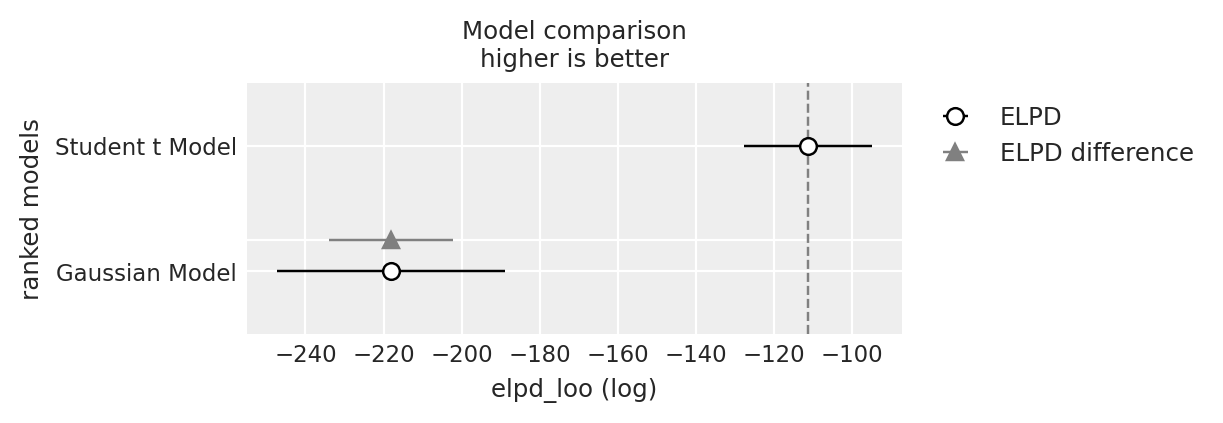

In [27]:
az.plot_compare(df_comp_loo, insample_dev=False);

Come abbiamo visto in precedenza, la ELPD (*Expected Log Predictive Density*) è una misura della performance predittiva di un modello statistico. Rappresenta il logaritmo della densità predittiva media attesa, calcolata attraverso la validazione incrociata LOO. Un valore più alto di ELPD indica una migliore capacità del modello di adattarsi ai dati e di fare previsioni accurate su nuovi dati non visti.

- **rank:** Posizione del modello basata sull'elpd_loo.
- **elpd_loo:** Stima dell'Expected Log Pointwise Predictive Density per LOO-CV. Valori più alti indicano migliori capacità predittive.
- **p_loo:** Stima della complessità effettiva del modello, che riflette il numero di parametri "effettivi".
- **elpd_diff:** Differenza di elpd_loo tra il modello corrente e il miglior modello. Per il miglior modello, questo valore è 0.
- **weight:** Peso basato sull'elpd_loo, indicando l'importanza relativa del modello nel contesto di un ensemble di modelli.
- **se (Standard Error):** Errore standard dell'elpd_loo.
- **dse (Differenza di Standard Error):** Errore standard della differenza di elpd_loo tra due modelli.
- **warning:** Se vero, indica potenziali problemi con la stima elpd_loo per il modello.
- **scale:** La scala utilizzata per misurare l'elpd_loo; in questo caso, "log".

Il modello Student t ha un elpd_loo di `-102.284333`, il che lo rende il modello con le migliori capacità predittive tra i due, poiché ha il valore elpd_loo più alto (meno negativo). Questo modello ha anche un `p_loo` di `5.894299`, indicando una complessità inferiore rispetto al Gaussian Model. Non ci sono avvertimenti, il che suggerisce che la stima elpd_loo è considerata affidabile. Ha ricevuto un peso di `1.000000`, indicando che è il modello preferito per le previsioni.

Il modello gaussiano mostra un elpd_loo di `-219.324176` con una differenza di elpd_loo (`elpd_diff`) di `117.039843` rispetto al miglior modello. Questo indica che ha prestazioni significativamente peggiori in termini di adattamento predittivo rispetto allo Student t Model. Il suo `p_loo` più alto di `15.391340` riflette una maggiore complessità del modello, che non sembra tradursi in migliori capacità predittive in questo contesto. Il modello presenta anche un avvertimento, il che potrebbe indicare problemi con la stima LOO, suggerendo cautela nell'interpretazione dei suoi risultati.

Basandosi sull'output fornito, il modello Student t è considerato il modello migliore tra i due per questi dati, dato il suo elpd_loo più alto (meno negativo), la minore complessità (p_loo inferiore), e l'assenza di avvertimenti. Il Gaussian Model, nonostante una maggiore complessità, mostra prestazioni inferiori e problemi potenziali (come indicato dall'avvertimento), rendendolo meno preferibile per la predizione su questo set di dati.

## Commenti e considerazioni conclusive

Nella pratica statistica, si incontrano spesso situazioni in cui l'eterogeneità non osservata - variazioni o differenze tra osservazioni in un insieme di dati che non sono spiegabili attraverso le variabili misurabili nel contesto dello studio - svolge un ruolo significativo. Questa eterogeneità si manifesta quando le differenze osservate tra i dati non possono essere attribuite completamente alle variabili note e misurabili. Al contrario, esistono fattori ignoti o non misurati che influenzano le osservazioni, che possono essere intrinseci alle unità di osservazione o dipendere da condizioni ambientali o contestuali non contemplate durante la progettazione dello studio o la raccolta dei dati.

Per modellare questa eterogeneità, spesso si utilizzano miscele di distribuzioni gaussiane o Student-t. La scelta della distribuzione Student-t in particolare implica un modello che è meno sensibile agli effetti dei valori estremi, o "outliers", grazie alle sue code più pesanti. Tuttavia, una sfida nella modellazione statistica risiede nel corretto posizionamento dei parametri dei gradi di libertà della distribuzione Student-t, specialmente perché gli outliers sono eventi rari e quindi difficili da stimare accuratamente.

In assenza di una teoria solida per guidare la scelta del modello statistico, la regressione robusta, basata su una distribuzione Student-t, emerge come una strategia prudente. Questo approccio si contrappone alla metodologia gaussiana standard, che può risultare inadeguata nel gestire gli effetti dei valori estremi e dell'eterogeneità non osservata.

È fondamentale, inoltre, valutare accuratamente la bontà di adattamento del modello ai dati. Strumenti come il Pareto Smoothed Importance Sampling (PSIS) e i valori diagnostici Pareto $ k $ si rivelano preziosi in questo contesto. Il PSIS utilizza la stima di $ k $ per perfezionare l'adattamento del modello, mentre i valori di $ k $ funzionano come indicatori diagnostici per valutare la qualità dell'importance sampling e l'adeguatezza del modello stesso. Questi metodi aiutano a sviluppare modelli più robusti e precisi, specialmente quando si trattano dati complessi con caratteristiche quali outliers e eterogeneità non osservata.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Thu Jun 13 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

matplotlib: 3.8.4
bambi     : 0.13.0
pymc      : 5.15.1
pandas    : 2.2.2
numpy     : 1.26.4
arviz     : 0.18.0
seaborn   : 0.13.2
scipy     : 1.13.1

Watermark: 2.4.3

